In [57]:
import os
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
from collections import Counter



In [ ]:
data_folder = "C:/Users/marty/Desktop/Thesis/Twitter dataset/archive/data/twitter"

In [30]:
def load_graph(edge_file):
    G = nx.Graph()
    edges = pd.read_csv(edge_file, sep=" ", names=["id_1", "id_2"], header=None)
    G.add_edges_from(edges.values)
    return G


In [34]:
# Get all .edges files in the dataset
edge_files = [f for f in os.listdir(data_folder) if f.endswith('.edges')]


In [ ]:
# Load the first edges file for preview
edge_path = os.path.join(data_folder, edge_files[0])
edges = pd.read_csv(edge_path, sep=" ", names=["id_1", "id_2"], header=None)

# Display
print("Edges:")
print(edges.head())

Edges:
        id_1       id_2
0  214328887   34428380
1   17116707   28465635
2  380580781   18996905
3  221036078  153460275
4  107830991   17868918


this shows a connection between two tweeter users

* Load only one of the graphs: 

In [ ]:
# Load only one graph for analysis
edge_path = os.path.join(data_folder, edge_files[0])
G = load_graph(edge_path)



In [ ]:
# Print basic graph statistics for this ego network 
print(f"Graph Loaded: {edge_files[0]}")
print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")

Graph Loaded: 100318079.edges
Number of nodes: 220
Number of edges: 5971


Nodes represent individual Twitter users in the ego network and edges represent connections (interactions or friendships) between users. So --> this ego network consists of 220 Twitter users and there are 5971 connections between them --> so they seem highly correlated

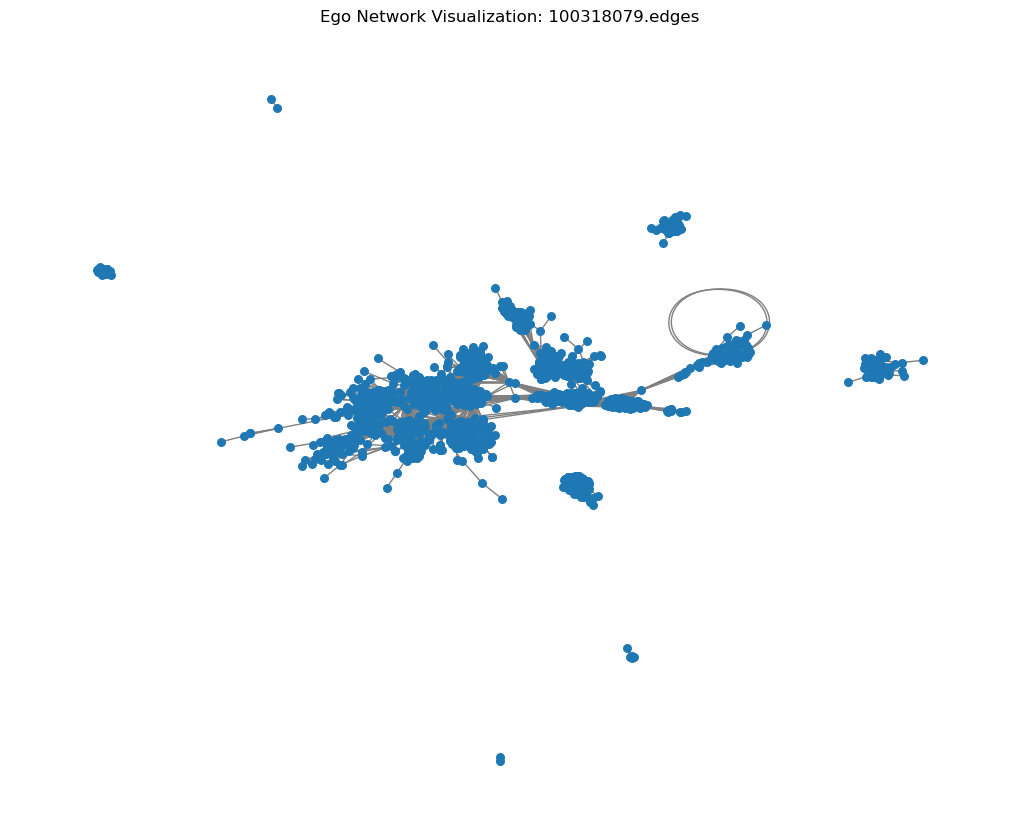

In [44]:
# Plot the ego network
plt.figure(figsize=(10, 8))
nx.draw(G, node_size=30, edge_color="gray", with_labels=False)
plt.title(f"Ego Network Visualization: {edge_files[0]}")
plt.show()


Highly clustered --> dense connection; some isolated nodes  

Loading all the graphs:

In [45]:
# Load the combined graph
G_combined = load_graph_from_edges(edge_files, data_folder)

Degree Distribution Summary (Combined Graph):
count    2576.000000
mean       26.998447
std        27.171801
min         1.000000
25%         8.000000
50%        18.000000
75%        38.000000
max       270.000000
dtype: float64


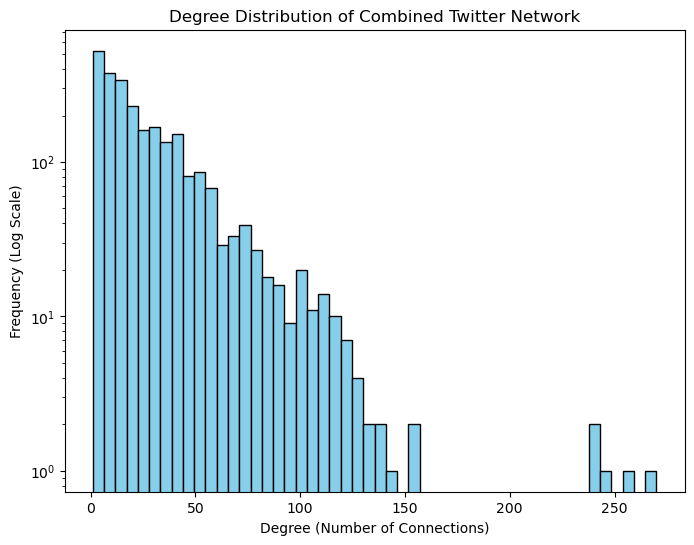

In [50]:
degree_dict_combined = dict(G_combined.degree())  # Compute degree for all nodes
degree_series_combined = pd.Series(degree_dict_combined)  # Convert to Pandas Series

# Print summary statistics
print("Degree Distribution Summary (Combined Graph):")
print(degree_series_combined.describe())

#plot degree distribution
plt.figure(figsize=(8, 6))
plt.hist(degree_series_combined, bins=50, color='skyblue', edgecolor='black', log=True)  # Log scale
plt.xlabel("Degree (Number of Connections)")
plt.ylabel("Frequency (Log Scale)")
plt.title("Degree Distribution of Combined Twitter Network")
plt.show()



Most nodes have low connectivity (1–50 connections) --> low-degree nodes
A small number of nodes are highly connected --> high-degree nodes

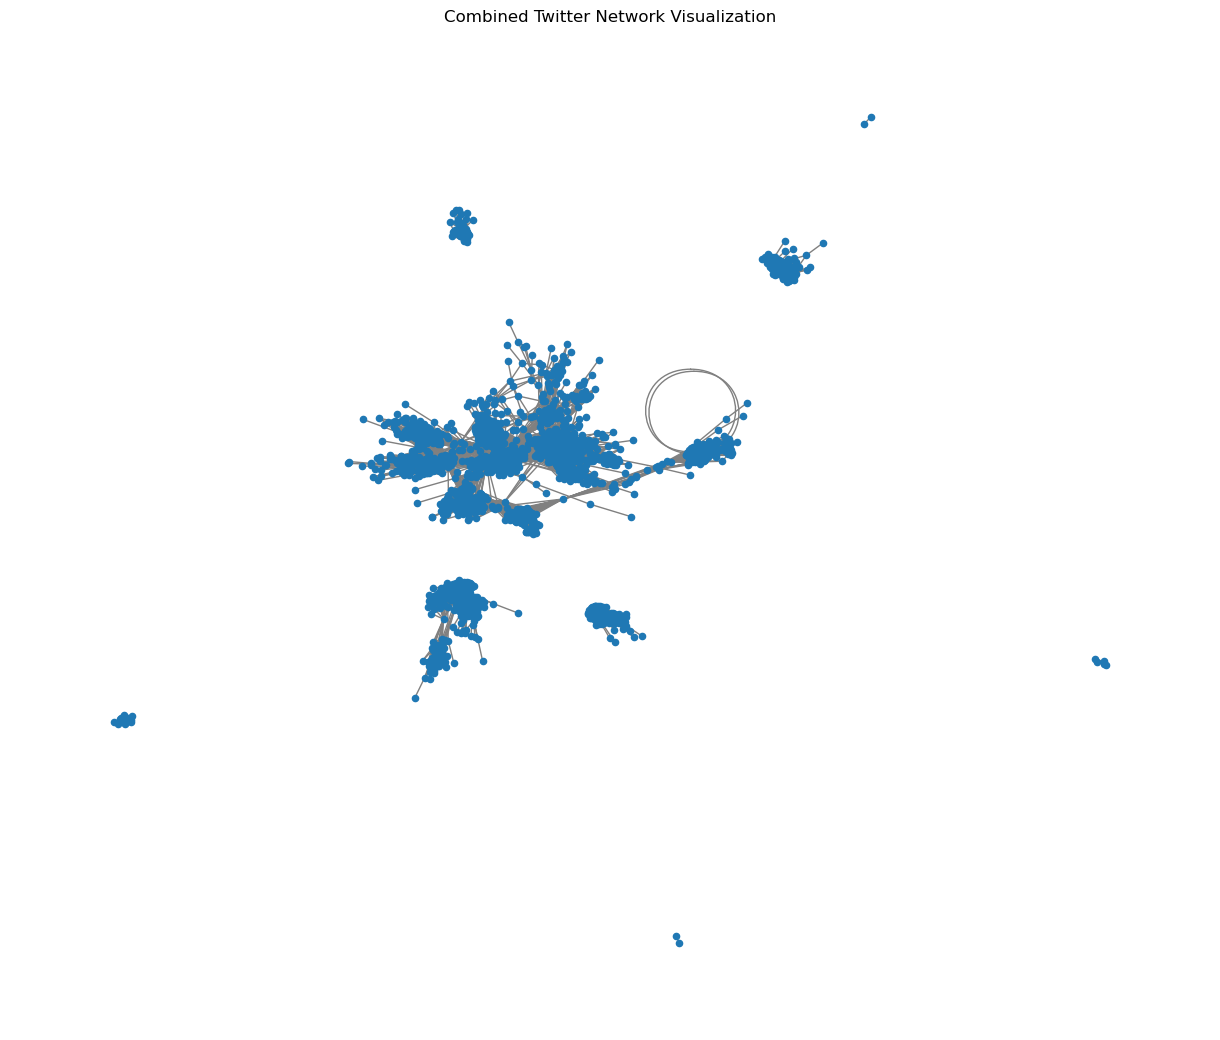

In [49]:
plt.figure(figsize=(12, 10))
nx.draw(G_combined, node_size=20, edge_color="gray", with_labels=False)
plt.title("Combined Twitter Network Visualization")
plt.show()


The center of the network has many interconnected nodes, there are several small clusters on the edges, multiple ego networks interacting

In [51]:
print("Combined Graph Statistics:")
print(f"Total number of nodes: {G_combined.number_of_nodes()}")
print(f"Total number of edges: {G_combined.number_of_edges()}")
print(f"Graph Density: {nx.density(G_combined):.4f}")

Combined Graph Statistics:
Total number of nodes: 2576
Total number of edges: 34774
Graph Density: 0.0105


there are 2576 users, 34 774 connections between them --> connections > users so multiple connections 
most users are not connected to each other directly (low density) but through intermediaries 

In [52]:
# Load feature names
featnames_path = os.path.join(data_folder, edge_files[0].replace(".edges", ".featnames"))
feat_names = pd.read_csv(featnames_path, sep=" ", header=None)
print(feat_names.head())


   0              1
0  0           #...
1  1             #1
2  2  #10bandsilove
3  3             #2
4  4            #20


maybe features correspond to hashtags, interests or groups that users are part of.

In [58]:
# Get all .featnames files in the dataset
featname_files = [f for f in os.listdir(data_folder) if f.endswith('.featnames')]

# Initialize a Counter to count feature occurrences
feature_counter = Counter()

# Read each .featnames file and count occurrences
for file in featname_files:
    featnames_path = os.path.join(data_folder, file)
    
    # Read feature names file
    with open(featnames_path, "r", encoding="utf-8") as f:
        for line in f:
            parts = line.strip().split(" ", 1)  # Split ID and feature name
            if len(parts) > 1:  # Ensure there is a feature name
                feature_name = parts[1]
                feature_counter[feature_name] += 1

# Get the 5 most common feature names
top_features = feature_counter.most_common(5)

# Display results
print("Top 5 Most Frequent Feature Names:")
for name, count in top_features:
    print(f"{name}: {count} occurrences")

Top 5 Most Frequent Feature Names:
#FF: 19 occurrences
@youtube: 16 occurrences
#ff: 15 occurrences
#...: 14 occurrences
#1: 14 occurrences


The fact that the most frequent feature appears only 19 times among 2,576 nodes suggests that features alone are unlikely to be the primary driver of connectivity --> edges not features determine the network structure 

In [53]:
# Load node features
feat_path = os.path.join(data_folder, edge_files[0].replace(".edges", ".feat"))
features = pd.read_csv(feat_path, sep=" ", header=None)
print(features.head())


        0     1     2     3     4     5     6     7     8     9     ...  1161  \
0   35415466     0     0     0     0     0     0     0     0     0  ...     0   
1  189875309     0     0     0     0     0     0     0     0     0  ...     0   
2  153226312     0     0     0     0     0     0     0     0     0  ...     0   
3  276706356     0     0     0     0     0     0     0     0     0  ...     0   
4  276308596     0     0     0     0     0     0     0     0     0  ...     0   

   1162  1163  1164  1165  1166  1167  1168  1169  1170  
0     0     0     0     0     0     0     0     0     0  
1     0     0     0     0     0     0     0     0     0  
2     1     0     0     0     0     0     0     0     0  
3     0     0     0     0     0     0     0     0     0  
4     1     0     0     0     0     0     0     0     0  

[5 rows x 1171 columns]


each row is different user and each column is a different feature
the features are binary values which suggests that it indicated if the user posseses a specific feature 

In [54]:
num_nodes = features.shape[0]
num_features = features.shape[1] - 1  # First column is likely the node ID

print(f"Total Nodes with Features: {num_nodes}")
print(f"Each Node has {num_features} Features")


Total Nodes with Features: 220
Each Node has 1170 Features


In [59]:
# Define High-Degree and Low-Degree Thresholds
high_degree_threshold = degree_series_combined.quantile(0.90)  # Top 10% most connected nodes
low_degree_threshold = degree_series_combined.quantile(0.10)   # Bottom 10% least connected nodes

# Extract nodes based on their degree
high_degree_nodes = degree_series_combined[degree_series_combined >= high_degree_threshold].index
low_degree_nodes = degree_series_combined[degree_series_combined <= low_degree_threshold].index

# Print results
print(f"High-degree Nodes: {len(high_degree_nodes)}")
print(f"Low-degree Nodes: {len(low_degree_nodes)}")


High-degree Nodes: 259
Low-degree Nodes: 270


close in size (256 vs 270) - balances comparison 

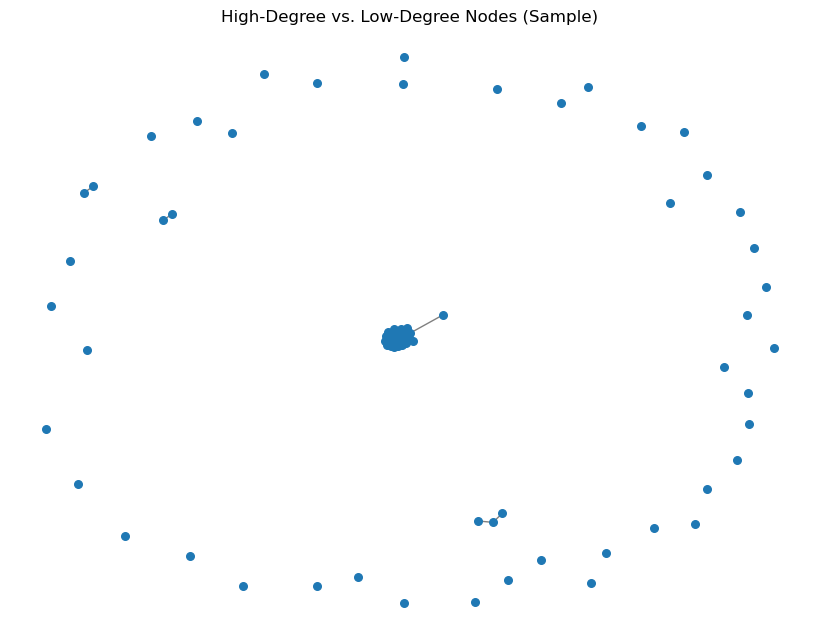

In [60]:
# Sample a subset of high-degree and low-degree nodes for visualization
subgraph_nodes = list(high_degree_nodes)[:50] + list(low_degree_nodes)[:50]
subG = G_combined.subgraph(subgraph_nodes)

# Plot the subgraph
plt.figure(figsize=(8, 6))
nx.draw(subG, node_size=30, edge_color="gray")
plt.title("High-Degree vs. Low-Degree Nodes (Sample)")
plt.show()


high-degree nodes form a central cluster and  low-degree nodes are more scattered in the periphery